# **1. Simple Functional API**

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model

In [6]:
x = Input(shape=(3,))

In [7]:
hidden1 = Dense(128, activation='relu')(x)
hidden2 = Dense(64, activation='relu')(hidden1)

output1 = Dense(1, activation='linear')(hidden2)
output2 = Dense(1, activation='softmax')(hidden2)

In [8]:
model1 = Model(inputs=x, outputs=[output1, output2])

In [9]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,898 (34.76 KB)

 Trainable params: 8,898 (34.76 KB)

 Non-trainable params: 0 (0.00 B)

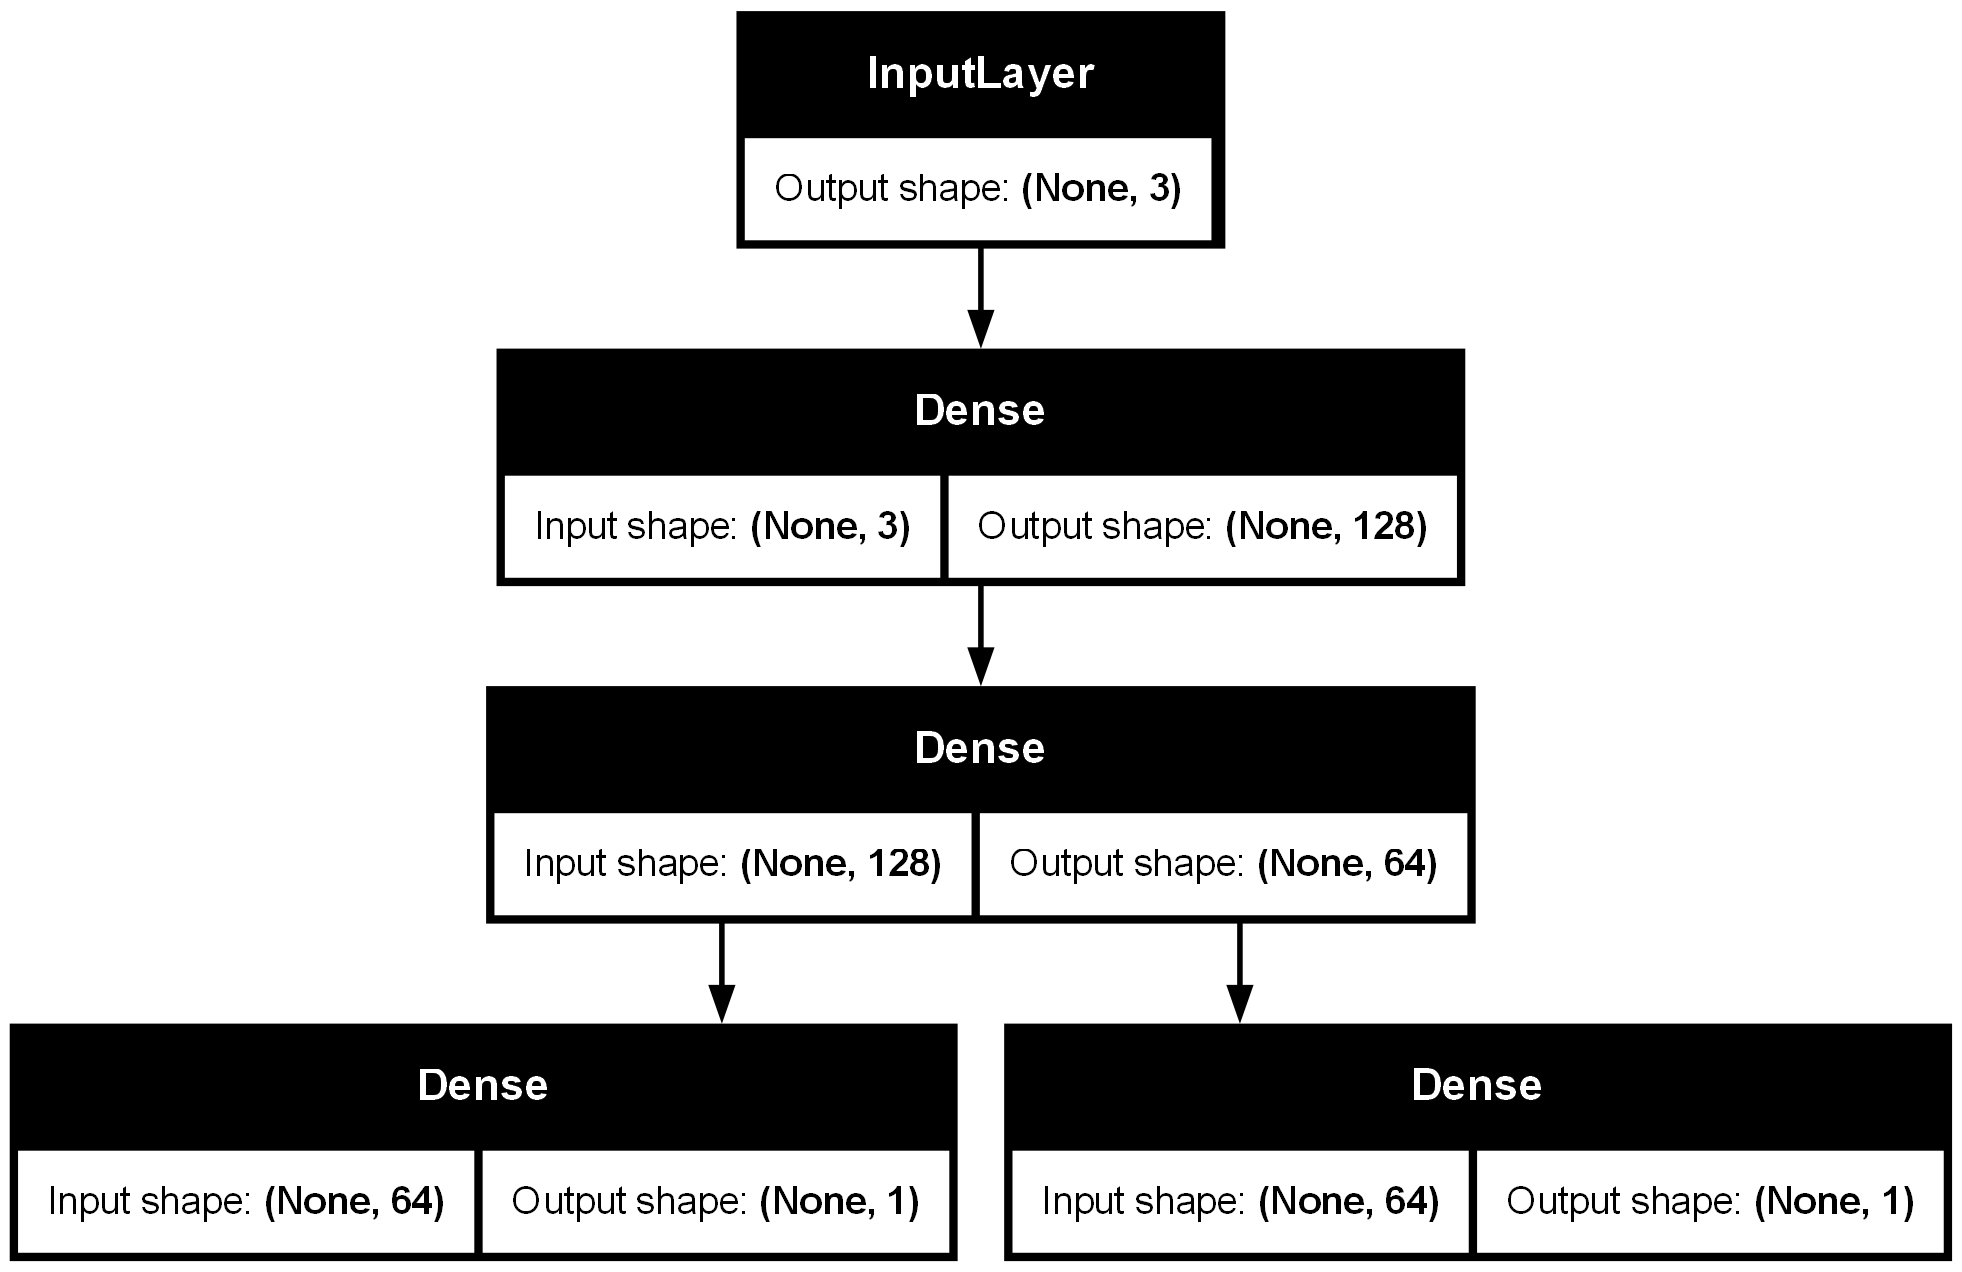

In [10]:
from keras.utils import plot_model
plot_model(model1,show_shapes=True)

# **2. Functional API Multiple Inputs**

In [12]:
input1 = Input(shape=(32,))
input2 = Input(shape=(128,))

In [15]:
x = Dense(16,activation='relu')(input1)
x1 = Dense(8,activation='relu')(x)

In [16]:
y = Dense(64,activation='relu')(input2)
y1 = Dense(32,activation='relu')(y)
y2 = Dense(16,activation='relu')(y1)

In [17]:
combined = concatenate([x1,y2])

In [21]:
z = Dense(2,activation='relu')(combined)
z1 = Dense(1,activation='linear')(z)

In [23]:
model2 = Model(inputs = [input1,input2], outputs = z1)

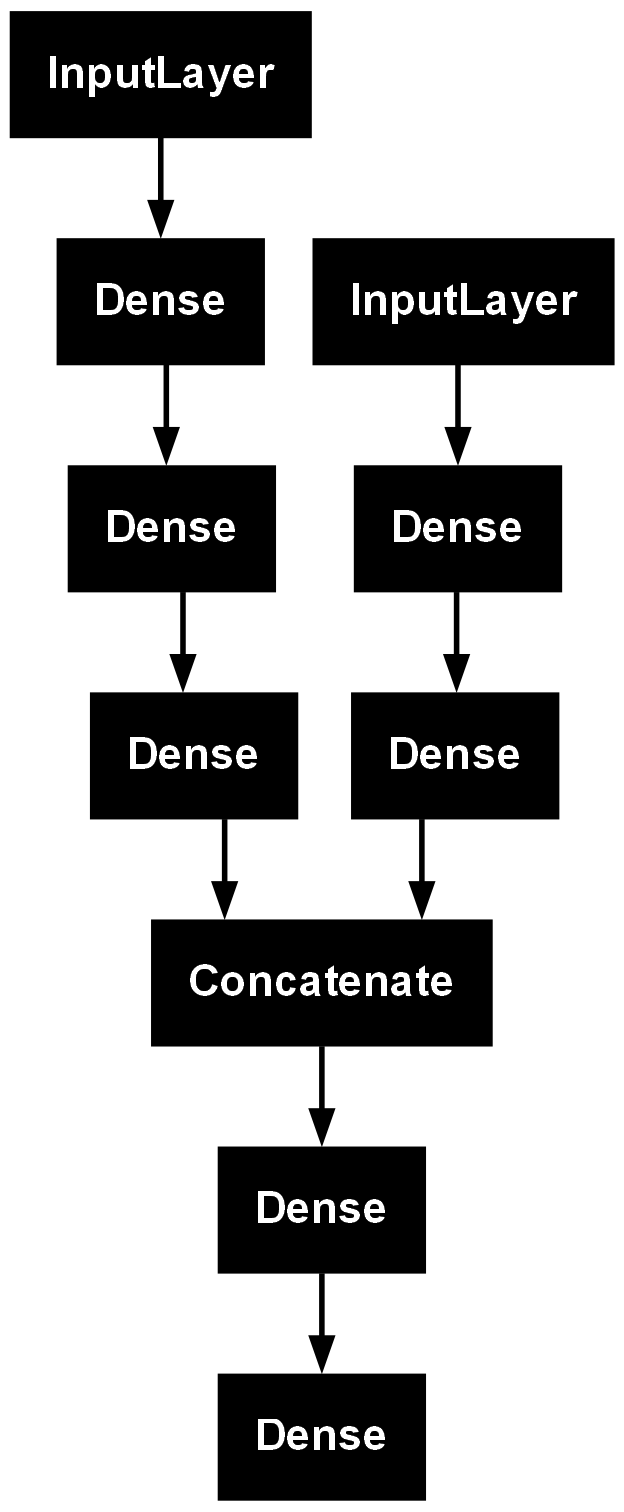

In [24]:
plot_model(model2)

# **3. `Age` & `Gender` Pridiction**

In [257]:
folder_path = 'UTKFace'

In [258]:
import os
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [259]:
len(age)

23708

In [260]:
import pandas as pd
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [261]:
df.shape

(23708, 3)

In [262]:
df.head()

,age,gender,img
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [263]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [264]:
train_df.shape

(20000, 3)

In [265]:
test_df.shape

(3708, 3)

In [266]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [268]:
train_gen_raw = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

test_gen_raw = test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [269]:
from tensorflow.keras.utils import Sequence

class MultiOutputWrapper(Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        X, y = self.generator[idx]   # y is shape (batch,2) but dtype=object
        
        # Convert y → float32 numeric array
        y = np.array(y).astype("float32")   # now (batch,2)

        return X, {
            "age": y[:, 0],          # regression output
            "gender": y[:, 1]        # binary output
        }


In [270]:
train_generator = MultiOutputWrapper(train_gen_raw)
test_generator = MultiOutputWrapper(test_gen_raw)

In [271]:
# import matplotlib.pyplot as plt
# # Plotting function
# def plot_images(generator, num_images=9):
#     plt.figure(figsize=(10, 10))
#     for i in range(num_images):
#         # Get one batch of images and labels
#         x_batch, y_batch = next(generator)
#         # Select one image from the batch
#         img = x_batch[0]  # Get the first image
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(img)
#         plt.axis('off')  # Hide axes
#     plt.show()

# plot_images(train_generator)

In [276]:
from keras.layers import *
from keras.models import Model
from keras.applications import VGG16
import numpy as np

In [273]:
input_tensor = Input(shape=(200,200,3))

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=input_tensor
)

x = base_model.output
x = Flatten()(x)

# Age branch
age_fc1 = Dense(512, activation='relu')(x)
age_fc2 = Dense(256, activation='relu')(age_fc1)
age_output = Dense(1, activation='linear', name='age')(age_fc2)

# Gender branch
gen_fc1 = Dense(512, activation='relu')(x)
gen_fc2 = Dense(256, activation='relu')(gen_fc1)
gender_output = Dense(1, activation='sigmoid', name='gender')(gen_fc2)

# Final model
model3 = Model(inputs=base_model.input, outputs=[age_output, gender_output])


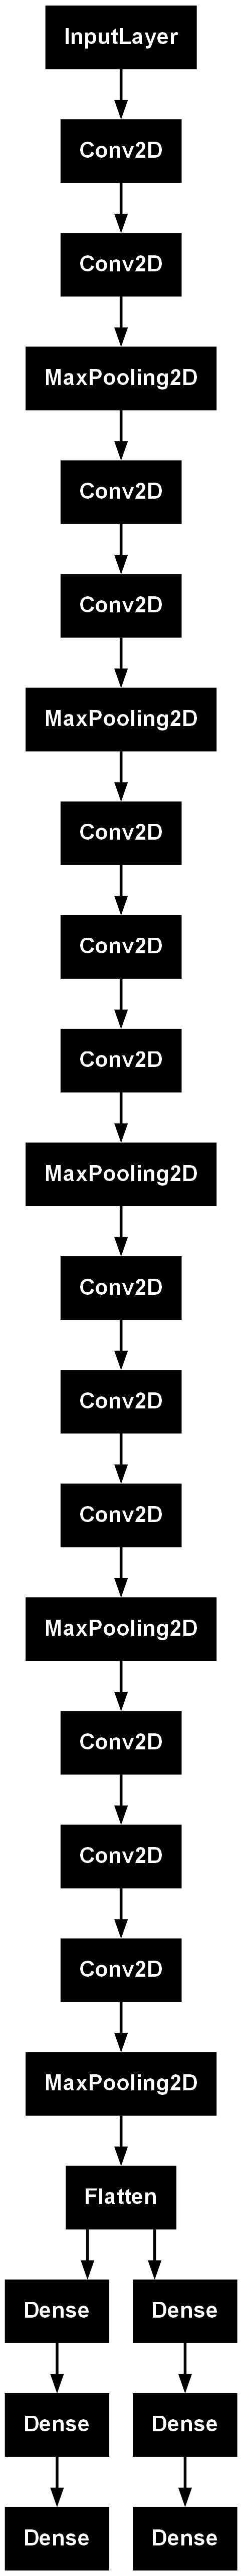

In [278]:
plot_model(model3)